In [1]:
# 统一导入工具包及显示设置
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
# 显示设置
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
import warnings
warnings.simplefilter('ignore')

In [2]:
# 读入数据
train_data = pd.read_csv('../raw_data/train_public.csv')
train1_data = pd.read_csv('../user_data/train_internet_4248.csv')
test_public = pd.read_csv('../raw_data/test_public.csv')
train_inte = pd.read_csv('../raw_data/train_internet.csv')
train_inte = train_inte.rename(columns={'is_default': 'isDefault'})
train_inte[['total_loan']]=train_inte[['total_loan']].astype(np.int64)

In [3]:
# 处理earlies_credit_mon函数
def clean_mon(x):
    mons = {'jan':1, 'feb':2, 'mar':3, 'apr':4,  'may':5,  'jun':6,
            'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    year_group = re.search('(\d+)', x)
    if year_group:
        year = int(year_group.group(1))
        if year < 22:
            year += 2000
        elif 100 > year > 22:
            year += 1900
        else:
            pass
    else:
        year = 2022
        
    month_group = re.search('([a-zA-Z]+)', x)
    if month_group:
        mon = month_group.group(1).lower()
        month = mons[mon]
    else:
        month = 0 
    return year*100 + month

# 统一处理日期
def process_date(data):
    data['issue_date'] = pd.to_datetime(data['issue_date'])
    data['issue_mon'] = data['issue_date'].dt.year * 100 + data['issue_date'].dt.month
    data['issue_date_dayofweek'] = data['issue_date'].dt.dayofweek
    data['earlies_credit_mon'] = data['earlies_credit_mon'].apply(lambda x: clean_mon(x))
    col_to_drop = ['issue_date','policy_code']
    data.drop(col_to_drop,axis=1,inplace=True)
    # 增加一个表示从开卡到这次发放贷款的间隔时间
    data['CreditLine'] = data['issue_mon']-data['earlies_credit_mon']
    return data

train_data = process_date(train_data)
test_public= process_date(test_public)
train_inte = process_date(train_inte)
train1_data = process_date(train1_data)

In [4]:
train_data.head(5)

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_mon,issue_date_dayofweek,CreditLine
0,1040418,240418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2,193,13,2.430,0,556.364,649.091,3,0,0.000,7734.231,91.800,0,0,200112,5,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0,201610,5,1498
1,1025197,225197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,0,491,30,11.005,1,715.000,893.750,3,0,0.000,31329.000,54.800,1,0,199004,40642,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0,201306,5,2302
2,1009360,209360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,4,459,8,6.409,0,774.545,903.636,5,0,0.000,18514.000,57.692,1,0,199110,154,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0,201401,2,2291
3,1039708,239708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,0,157,8,9.205,0,750.000,875.000,3,0,0.000,20707.000,42.600,0,0,200106,0,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0,201507,2,1401
4,1027483,227483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,0,38,21,15.578,0,609.091,710.606,15,0,0.000,14016.154,30.462,0,0,200205,0,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0,201607,4,1402


In [5]:
# 处理工作年数，类别数据等
from sklearn.preprocessing import LabelEncoder
def workYearDIc(x):
    if str(x) == 'nan':
        return -1
    x = x.replace('< 1', '0')
    return int(re.search('(\d+)', x).group())

class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

# 处理年份及各种特征工程
def process_year_cat(data):
    data['work_year'] = data['work_year'].map(workYearDIc)
    data['class'] = data['class'].map(class_dict)
    
#     增加一个表示客户评分平均分的属性
    data['scoring'] = (data['scoring_high']+data['scoring_low'])/2
    
#     清理错误数据，提前还款总额不为0，还款次数为0的置为1
    data.loc[(data['early_return']==0)&(data['early_return_amount']>0),['early_return']]=1
    
#     增加一个表示是否有提前还款的特征
    data.loc[data['early_return']>=1,['early_return_YN']]=1;
    data.loc[data['early_return']==0,['early_return_YN']]=0;
    
#     增加一个贷款类别是否为A的特征   
    data.loc[data['class']==1,['class_A']]=1;
    data.loc[data['class']!=1,['class_A']]=0;
    
#     增加一个表示是否有房的特征： 实际效果有所下降
    data.loc[data['house_exist']>=1,['house_YN']] = 1;
    data.loc[data['house_exist']==0,['house_YN']] = 0;

#     贷款金额/分期付款
    data['totloan_monpay'] = data['total_loan']/data['monthly_payment']
    
#     增加一个表示借款人是否在过去18个月逾期30天以上的违约
    data.loc[data['del_in_18month']>=1,['del_in_18month_YN']]=1;
    data.loc[data['del_in_18month']==0,['del_in_18month_YN']]=0;

#     增加一个是否清除公共记录的数量
    data.loc[data['pub_dero_bankrup']>=1,['pub_dero_bankrup_YN']]=1;
    data.loc[data['pub_dero_bankrup']==0,['pub_dero_bankrup_YN']]=0;
    cat_cols = ['employer_type','industry']
    for col in cat_cols:
        lbl = LabelEncoder().fit(data[col])
        data[col] = lbl.transform(data[col])
    return data

train_data = process_year_cat(train_data)
test_public = process_year_cat(test_public)
train_inte = process_year_cat(train_inte)
train1_data = process_year_cat(train1_data)

In [6]:
# 查找关联
corr_matrix = train_data.corr()
corr_matrix["isDefault"].sort_values(ascending=False)

isDefault                   1.000
class                       0.212
interest                    0.194
year_of_loan                0.127
f0                          0.089
debt_loan_ratio             0.081
censor_status               0.073
known_outstanding_loan      0.069
house_YN                    0.064
house_exist                 0.054
known_dero                  0.051
pub_dero_bankrup            0.044
earlies_credit_mon          0.038
pub_dero_bankrup_YN         0.038
recircle_u                  0.035
issue_mon                   0.031
f3                          0.022
del_in_18month_YN           0.022
totloan_monpay              0.019
del_in_18month              0.016
total_loan                  0.016
region                      0.010
monthly_payment             0.009
initial_list_status         0.009
f4                          0.008
post_code                   0.007
app_type                    0.004
f2                          0.004
employer_type              -0.001
f1            

In [7]:
#  train_cols: train_data中的属性， same_cols: 共同属性
train_cols = set(train_data.columns)
same_cols = list(train_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_cols].copy()
train1_dataSame = train1_data[same_cols].copy()
#  给internet数据添加与public一样的属性列，并设值为nan
Inte_add_cols = list(train_cols.difference(set(same_cols)))
for col in Inte_add_cols:
    train_inteSame[col] = np.nan
    train1_dataSame[col] = np.nan

train_data =  pd.concat([train_data,train1_dataSame]).reset_index(drop=True)

# 使用KNN填补数据
from sklearn.impute import KNNImputer
imputer  = KNNImputer(n_neighbors=10)
train_data_filled = imputer.fit_transform(train_data)
train_data = pd.DataFrame(train_data_filled,columns=train_data.columns)

In [8]:
train_data.shape

(14248, 47)

In [9]:
# 模型
import catboost as cb
from sklearn.model_selection import GridSearchCV
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault']]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_[feats],data_['isDefault'])):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        
        clf = cb.CatBoostClassifier(iterations=10000, 
                                      depth=7, 
                                      learning_rate=0.002, 
                                      loss_function='Logloss',
                                      eval_metric='AUC',
                                      logging_level='Verbose',
                                      metric_period=50)
        
        clf.fit(trn_x, trn_y,
                eval_set=[(trn_x, trn_y), (val_x, val_y)])
# ,verbose=50,early_stopping_rounds=200
        oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
        sub_preds += clf.predict_proba(test_[feats])[:, 1] / folds_.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(y_, oof_preds))

    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df


def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index

    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [10]:
y = train_data['isDefault']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)

# IntePre：返回test数据的id及对应预测结果
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

0:	test: 0.8295583	test1: 0.8310415	best: 0.8310415 (0)	total: 60.6ms	remaining: 10m 6s
50:	test: 0.8567199	test1: 0.8467540	best: 0.8467540 (50)	total: 477ms	remaining: 1m 33s
100:	test: 0.8581389	test1: 0.8484350	best: 0.8484350 (100)	total: 888ms	remaining: 1m 27s
150:	test: 0.8592880	test1: 0.8490082	best: 0.8490082 (150)	total: 1.3s	remaining: 1m 24s
200:	test: 0.8598244	test1: 0.8483860	best: 0.8490082 (150)	total: 1.87s	remaining: 1m 31s
250:	test: 0.8600339	test1: 0.8490002	best: 0.8490082 (150)	total: 2.5s	remaining: 1m 37s
300:	test: 0.8605852	test1: 0.8491473	best: 0.8491473 (300)	total: 2.99s	remaining: 1m 36s
350:	test: 0.8613667	test1: 0.8495421	best: 0.8495421 (350)	total: 3.65s	remaining: 1m 40s
400:	test: 0.8621862	test1: 0.8497165	best: 0.8497165 (400)	total: 4.23s	remaining: 1m 41s
450:	test: 0.8630792	test1: 0.8501523	best: 0.8501523 (450)	total: 4.67s	remaining: 1m 38s
500:	test: 0.8641256	test1: 0.8507424	best: 0.8507424 (500)	total: 5.12s	remaining: 1m 37s
550:	t

In [11]:
IntePre['isDef'] = train_inte['isDefault']
from sklearn.metrics import roc_auc_score

roc_auc_score(IntePre['isDef'], IntePre.isDefault)

0.751631005395508

In [12]:
IntePre.describe()

,loan_id,isDefault,isDef
count,750000.000,750000.000,750000.000
mean,400033.712,0.307,0.200
std,230968.542,0.169,0.400
min,0.000,0.000,0.000
25%,199923.750,0.182,0.000
50%,400077.500,0.303,0.000
75%,600051.250,0.430,0.000
max,799999.000,0.862,1.000


In [13]:
# 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId1 = IntePre.loc[(IntePre.isDefault < 0.05), 'loan_id'].tolist()
InteId2 = IntePre.loc[(IntePre.isDefault < 0.10)&(IntePre.isDefault>0.03), 'loan_id'].tolist()


train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['isDefault']
use_te1= train_inteSame[train_inteSame.loan_id.isin(InteId1)].copy()
use_te2= train_inteSame[train_inteSame.loan_id.isin(InteId2)].copy()
data1 = pd.concat([train_data, test_public, use_te1]).reset_index(drop=True)
data2 = pd.concat([train_data, test_public, use_te2]).reset_index(drop=True)
len(InteId1)

60106

In [14]:
len(InteId2)

24826

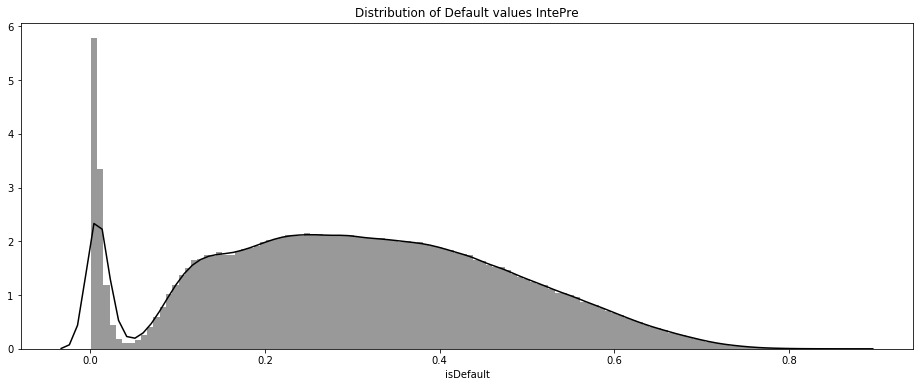

In [15]:
# IntePre.isDefault
plt.figure(figsize=(16, 6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'], color="black", kde=True, bins=120, label='train_data')

In [16]:
train1 = data1[data1['isDefault'].notna()]
train2 = data2[data2['isDefault'].notna()]
test = data1[data1['isDefault'].isna()]
print(len(train1))
print(len(train2))
# 填充test数据
# 使用KNN填补数据
from sklearn.impute import KNNImputer
imputer  = KNNImputer(n_neighbors=10)
test_data_filled = imputer.fit_transform(test)
imputer_columns=[]
for col in test.columns:
    if(col!='isDefault'):
        imputer_columns.append(col)

test = pd.DataFrame(test_data_filled,columns=imputer_columns)
#将测试集划分为是否提前还款
testId1 = test.loc[(test.early_return != 0), 'loan_id'].tolist()
testId2 = test.loc[(test.early_return == 0), 'loan_id'].tolist()
test1= test[test.loan_id.isin(testId1)].copy()
test2= test[test.loan_id.isin(testId2)].copy()

y1 = train1['isDefault']
print(len(y1))
print(len(train1))
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)
oof_preds1, test_preds1, importances1 = train_model(train1, test1, y1, folds)
test_preds1.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('../user_data/nn0.csv', index=False)


y2 = train2['isDefault'].copy()
print(len(y2))
print(len(train2))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)
oof_preds2, test_preds2, importances2 = train_model(train2, test2, y2, folds)
test_preds2.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('../user_data/nn1.csv', index=False)

test_preds= pd.concat([test_preds1, test_preds2]).reset_index(drop=True)
test_preds.to_csv('../user_data/nn2.csv', index=False) 

74354
39074
74354
74354
0:	test: 0.9545796	test1: 0.9460609	best: 0.9460609 (0)	total: 22.6ms	remaining: 3m 45s
50:	test: 0.9765292	test1: 0.9737395	best: 0.9737395 (50)	total: 843ms	remaining: 2m 44s
100:	test: 0.9768014	test1: 0.9737867	best: 0.9737867 (100)	total: 1.87s	remaining: 3m 2s
150:	test: 0.9771058	test1: 0.9738828	best: 0.9738828 (150)	total: 3.17s	remaining: 3m 26s
200:	test: 0.9771521	test1: 0.9738859	best: 0.9738859 (200)	total: 4.48s	remaining: 3m 38s
250:	test: 0.9772175	test1: 0.9738027	best: 0.9738859 (200)	total: 5.46s	remaining: 3m 31s
300:	test: 0.9773134	test1: 0.9737851	best: 0.9738859 (200)	total: 6.33s	remaining: 3m 24s
350:	test: 0.9774225	test1: 0.9737650	best: 0.9738859 (200)	total: 7.19s	remaining: 3m 17s
400:	test: 0.9776341	test1: 0.9738366	best: 0.9738859 (200)	total: 8.05s	remaining: 3m 12s
450:	test: 0.9777711	test1: 0.9739486	best: 0.9739486 (450)	total: 8.88s	remaining: 3m 8s
500:	test: 0.9779527	test1: 0.9740945	best: 0.9740945 (500)	total: 9.72s	

In [17]:
test.info()
print(test_data_filled.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   5000 non-null   float64
 1   user_id                   5000 non-null   float64
 2   total_loan                5000 non-null   float64
 3   year_of_loan              5000 non-null   float64
 4   interest                  5000 non-null   float64
 5   monthly_payment           5000 non-null   float64
 6   class                     5000 non-null   float64
 7   employer_type             5000 non-null   float64
 8   industry                  5000 non-null   float64
 9   work_year                 5000 non-null   float64
 10  house_exist               5000 non-null   float64
 11  censor_status             5000 non-null   float64
 12  use                       5000 non-null   float64
 13  post_code                 5000 non-null   float64
 14  region  

In [18]:
# 将预测的值小于0.5的isDefault值设为0，并保存到一文件中，扩大训练集
train_data = pd.read_csv('../raw_data/train_public.csv')
test_data = pd.read_csv('../raw_data/test_public.csv')
sub = pd.read_csv("../user_data/nn2.csv")
sub = sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault'] < 0.50, 'isDefault'] = 0
sub.loc[sub['isDefault'] > 0.68, 'isDefault'] = 1
nw_sub0 = sub[(sub['isDefault'] == 0)]
nw_sub1 = sub[(sub['isDefault'] == 1)]
nw_test_data0 = test_data.merge(nw_sub0, on='loan_id', how='inner')
nw_test_data1 = test_data.merge(nw_sub1, on='loan_id', how='inner')
nw_train_data = pd.concat([train_data, nw_test_data0,nw_test_data1]).reset_index(drop=True)
nw_train_data.to_csv("../user_data/nw_train_public.csv", index=0)
nw_test_data1.shape

(48, 39)

In [19]:
nw_test_data0

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1000575,200575,2890.909,3,10.791,88.010,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.040,0,745.000,869.167,7,0,0.000,8647.692,31.846,1,0,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192,0.000
1,1028125,228125,7272.727,3,9.990,258.100,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.755,0,681.818,738.636,24,0,0.000,9406.154,18.277,0,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,0.000
2,1010694,210694,26295.455,3,15.763,764.030,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.495,1,758.182,947.727,11,0,0.000,26414.769,62.300,1,0,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,0.000
3,1026712,226712,22690.909,5,19.305,524.300,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.620,0,572.727,620.455,8,0,0.000,1198.000,7.700,0,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,0.000
4,1002895,202895,14545.455,3,7.139,490.320,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.611,0,638.182,691.364,15,0,0.000,3920.000,8.831,1,0,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,1008856,208856,9454.545,5,12.015,183.470,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,1,0,2011/1/1,0,48,10,14.900,0,568.636,710.795,11,0,0.000,5370.462,75.785,1,0,5-Jul,10595,1,nan,nan,nan,nan,nan,0,0,0.000,0.000
4546,1016651,216651,5500.000,3,7.970,172.280,A,政府机构,房地产业,5 years,1,0,2017/5/1,0,31,2,12.160,0,796.364,995.455,5,0,0.000,6326.538,43.077,0,0,12-Apr,0,1,3.000,0.000,2.000,5.000,3.000,3,1564,0.000,0.000
4547,1024140,224140,30545.455,3,8.900,889.090,A,上市企业,房地产业,10+ years,0,2,2013/12/1,0,464,37,21.550,0,710.000,769.167,17,0,0.000,63903.692,79.385,0,0,Oct-86,21735,1,8.000,0.000,17.000,20.000,14.000,2,5456,1510.892,0.000
4548,1014316,214316,4090.909,3,6.030,152.180,A,政府机构,文化和体育业,10+ years,0,2,2012/9/1,0,566,30,13.222,0,709.091,768.182,7,0,0.000,2703.692,29.423,1,0,Mar-99,24272,1,1.000,0.000,6.000,10.000,10.000,3,223,41.169,0.000


In [20]:
train_data.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430,0,556.364,649.091,3,0,0.000,7734.231,91.800,0,0,1-Dec,5,1,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0
1,1025197,225197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.005,1,715.000,893.750,3,0,0.000,31329.000,54.800,1,0,Apr-90,40642,1,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0
2,1009360,209360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409,0,774.545,903.636,5,0,0.000,18514.000,57.692,1,0,Oct-91,154,1,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0
3,1039708,239708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.205,0,750.000,875.000,3,0,0.000,20707.000,42.600,0,0,1-Jun,0,1,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0
4,1027483,227483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578,0,609.091,710.606,15,0,0.000,14016.154,30.462,0,0,2-May,0,1,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0


In [21]:
train_data = pd.read_csv('../user_data/nw_train_public.csv')
train1_data = pd.read_csv("../user_data/train_internet_4248.csv")
test_public = pd.read_csv('../raw_data/test_public.csv')
train_inte = pd.read_csv('../raw_data/train_internet.csv')
train_inte = train_inte.rename(columns={'is_default': 'isDefault'})
train_inte[['total_loan']]=train_inte[['total_loan']].astype(np.int64)

In [22]:
# 处理datetime数据
train_data = process_date(train_data)
test_public= process_date(test_public)
train_inte = process_date(train_inte)
train1_data = process_date(train1_data)

# 处理年数和类别数据
train_data = process_year_cat(train_data)
test_public = process_year_cat(test_public)
train_inte = process_year_cat(train_inte)
train1_data = process_year_cat(train1_data)

In [23]:
# train_cols: train_data中的属性， same_cols: 共同属性
train_cols = set(train_data.columns)
same_cols = list(train_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_cols].copy()
train1_dataSame = train1_data[same_cols].copy()
# 给internet数据添加与public一样的属性列，并设值为nan
Inte_add_cols = list(train_cols.difference(set(same_cols)))
for col in Inte_add_cols:
    train_inteSame[col] = np.nan
    train1_dataSame[col] = np.nan

train_data =  pd.concat([train_data,train1_dataSame]).reset_index(drop=True)

# 使用KNN填补数据
from sklearn.impute import KNNImputer
imputer  = KNNImputer(n_neighbors=10)
train_data_filled = imputer.fit_transform(train_data)
train_data = pd.DataFrame(train_data_filled,columns=train_data.columns)

In [24]:
y = train_data['isDefault']
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)

# IntePre：返回test数据的id及对应预测结果
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

0:	test: 0.8530566	test1: 0.8496782	best: 0.8496782 (0)	total: 12.7ms	remaining: 2m 7s
50:	test: 0.8774379	test1: 0.8607249	best: 0.8607249 (50)	total: 448ms	remaining: 1m 27s
100:	test: 0.8788373	test1: 0.8621408	best: 0.8621408 (100)	total: 884ms	remaining: 1m 26s
150:	test: 0.8791785	test1: 0.8626510	best: 0.8626510 (150)	total: 1.32s	remaining: 1m 26s
200:	test: 0.8791822	test1: 0.8620700	best: 0.8626510 (150)	total: 1.76s	remaining: 1m 25s
250:	test: 0.8794503	test1: 0.8617822	best: 0.8626510 (150)	total: 2.21s	remaining: 1m 25s
300:	test: 0.8799518	test1: 0.8618570	best: 0.8626510 (150)	total: 2.66s	remaining: 1m 25s
350:	test: 0.8806380	test1: 0.8618644	best: 0.8626510 (150)	total: 3.12s	remaining: 1m 25s
400:	test: 0.8816095	test1: 0.8623429	best: 0.8626510 (150)	total: 3.57s	remaining: 1m 25s
450:	test: 0.8823881	test1: 0.8626669	best: 0.8626669 (450)	total: 4.01s	remaining: 1m 24s
500:	test: 0.8832786	test1: 0.8630860	best: 0.8630860 (500)	total: 4.48s	remaining: 1m 25s
550:	

In [25]:
IntePre['isDef'] = train_inte['isDefault']
from sklearn.metrics import roc_auc_score

roc_auc_score(IntePre['isDef'], IntePre.isDefault)

0.7540290100377229

In [26]:
InteId1 = IntePre.loc[(IntePre.isDefault < 0.05), 'loan_id'].tolist()
InteId2 = IntePre.loc[(IntePre.isDefault < 0.10)&(IntePre.isDefault>0.03), 'loan_id'].tolist()


train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['isDefault']
use_te1= train_inteSame[train_inteSame.loan_id.isin(InteId1)].copy()
use_te2= train_inteSame[train_inteSame.loan_id.isin(InteId2)].copy()
data1 = pd.concat([train_data, test_public, use_te1]).reset_index(drop=True)
data2 = pd.concat([train_data, test_public, use_te2]).reset_index(drop=True)

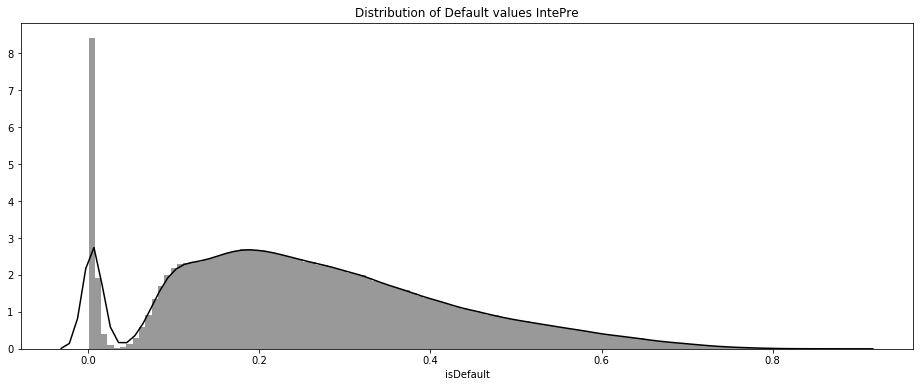

In [27]:
# IntePre.isDefault
plt.figure(figsize=(16, 6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'], color="black", kde=True, bins=120, label='train_data')

In [28]:
train1 = data1[data1['isDefault'].notna()]
train2 = data2[data2['isDefault'].notna()]
test = data1[data1['isDefault'].isna()]


testId1 = test.loc[(test.early_return != 0), 'loan_id'].tolist()
testId2 = test.loc[(test.early_return == 0), 'loan_id'].tolist()
test1= test[test.loan_id.isin(testId1)].copy()
test2= test[test.loan_id.isin(testId2)].copy()
print(test1.info())


y1 = train1['isDefault']
print(len(y1))
print(len(train1))
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)
oof_preds1, test_preds1, importances1 = train_model(train1, test1, y1, folds)
test_preds1=test_preds1.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']]


y2 = train2['isDefault'].copy()
print(len(y2))
print(len(train2))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=202110)
oof_preds2, test_preds2, importances2 = train_model(train2, test2, y2, folds)
test_preds2=test_preds2.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']]

test_preds= pd.concat([test_preds1, test_preds2]).reset_index(drop=True)
test_preds.to_csv('../prediction_result/result.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3607 entries, 18846 to 23845
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   3607 non-null   float64
 1   user_id                   3607 non-null   float64
 2   total_loan                3607 non-null   float64
 3   year_of_loan              3607 non-null   float64
 4   interest                  3607 non-null   float64
 5   monthly_payment           3607 non-null   float64
 6   class                     3607 non-null   float64
 7   employer_type             3607 non-null   float64
 8   industry                  3607 non-null   float64
 9   work_year                 3607 non-null   float64
 10  house_exist               3607 non-null   float64
 11  censor_status             3607 non-null   float64
 12  use                       3607 non-null   float64
 13  post_code                 3607 non-null   float64
 14  reg

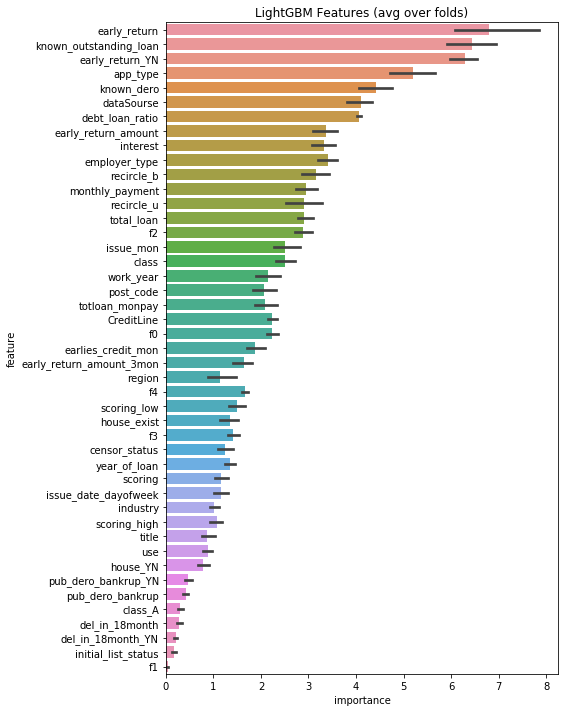

In [29]:
display_importances(importances1)

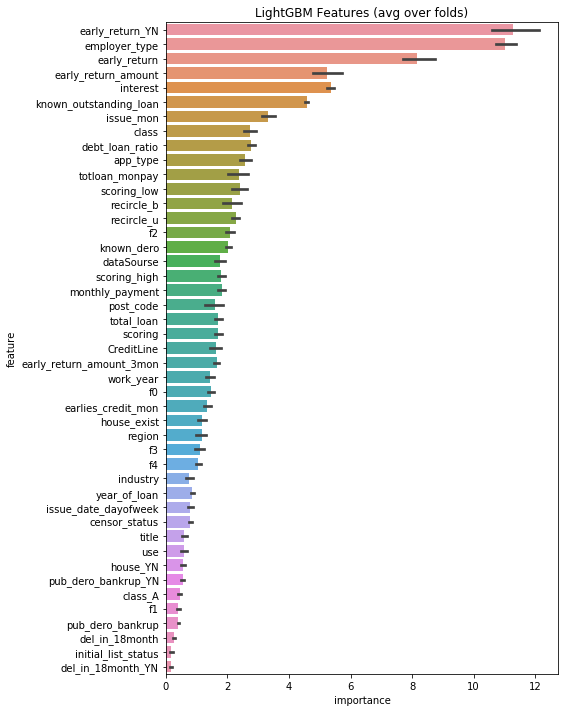

In [30]:
display_importances(importances2)